## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [214]:
!pip install spacy==3.4.3
!pip install -U pip setuptools wheel
#!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.9 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [215]:
!pip install plotly

In [216]:
!pip install textblob

In [217]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /home/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [218]:
!pip install wordcloud

In [219]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [220]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json',)# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
data=pd.json_normalize(data)


## Data preparation

In [221]:
# Inspect the dataframe to understand the given data.

data.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


#### INFERENCE: Topic of interest _source.complaint_what_happened column

In [222]:
#shape 
data.shape

(78313, 22)

In [223]:
# print column names
col_list=list(data.columns)
col_list

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [225]:
data.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


##### INFERENCE: _score is only numeric and all values  have '0'

In [226]:
def check_duplicates(data):
    row, column = data[data.duplicated()].shape
    print('There are no duplicates in the dataset.' if row==0 else f'There are {row} duplicates in the dataset.')

In [227]:
check_duplicates(data)

There are no duplicates in the dataset.


In [228]:
def percentage_missing(data):
    # Percentage of missing values
    print('\nPERCENTAGE MISSING VALUES:')
    c=0
    for feature in data:
        if data[feature].isnull().sum()!=0:
            print(f"The feature '{feature}' has {np.round((data[feature].isnull().mean()*100),2)}% missing values")
        else:
            c+=1
    if c == len(data.columns):print('There is no missing values in the dataset')
    print("\n")

In [229]:
# Inspect the number of missing values percentage
percentage_missing(data)


PERCENTAGE MISSING VALUES:
The feature '_source.tags' has 86.08% missing values
The feature '_source.zip_code' has 8.63% missing values
The feature '_source.state' has 2.54% missing values
The feature '_source.company_public_response' has 99.99% missing values
The feature '_source.sub_product' has 13.5% missing values
The feature '_source.sub_issue' has 59.12% missing values
The feature '_source.consumer_consent_provided' has 1.29% missing values




In [230]:
#Assign nan in place of blanks in the complaints column
# There are many blank rows in '_source.complaint_what_happened'. Converting them into NaN values
data['_source.complaint_what_happened'].replace("", np.nan, inplace=True)

In [231]:
# Inspect the number of missing values percentage
percentage_missing(data)


PERCENTAGE MISSING VALUES:
The feature '_source.tags' has 86.08% missing values
The feature '_source.zip_code' has 8.63% missing values
The feature '_source.state' has 2.54% missing values
The feature '_source.company_public_response' has 99.99% missing values
The feature '_source.sub_product' has 13.5% missing values
The feature '_source.complaint_what_happened' has 73.09% missing values
The feature '_source.sub_issue' has 59.12% missing values
The feature '_source.consumer_consent_provided' has 1.29% missing values




In [232]:
#Remove all rows where complaints column is nan
##_source.complaint_what_happened has 73.09 % of null values. Need to remove them
#Dropping NaN rows from "_source.complaint_what_happened"
data.dropna(subset=['_source.complaint_what_happened'], inplace=True)

#New shape of df
data.shape

(21072, 22)

In [233]:
#Assign new column names
#Removing "_" from column names
data.columns=[re.sub('^_','',col) for col in data.columns]

#Removing "source." from column names
data.columns = [re.sub(r"^\bsource\b\.", "", col) for col in data.columns]

list(data.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [234]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [235]:
data['complaint_what_happened']= data['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [236]:
#Write your function to Lemmatize the texts
# def lemma_texts(text):     
        
#     # Initialize empty list to store lemmas
#     lemma_list = []
    
#     # Extract lemmas of given text and add to the list 'sent'
#     document = nlp(text)
#     i=0
#     for word in document:    
#         lemma_list.append(word.lemma_)
       
        
        
#     # return string converted form of the list of lemmas
#     return " ".join(lemma_list)
def lemma_text(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

In [238]:
# Add a column for lemmatized complaints to the dataframe
data["lemmatized_complaint"] =  data.apply(lambda x: lemma_texts(x['complaint_what_happened']), axis=1)

# View the dataframe
data.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in xx/xx/ and was...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"chase card was reported on xx/xx/. however, fr...",Information belongs to someone else,Consent provided,"chase card be report on xx / xx/. however , fr..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"on xx/xx/, while trying to book a xxxx xxxx ...",Information belongs to someone else,Consent provided,"on xx / xx/ , while try to book a xxxx xxxx ..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$.} i deposit ...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for { $ . } I deposi...


In [239]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
data_clean=data[['complaint_what_happened','lemmatized_complaint']]

In [240]:
data_clean

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my..."
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...


In [241]:
!pip install swifter

In [242]:
#Write your function to extract the POS tags 
import swifter
def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
data_clean["complaint_POS_removed"] =  data_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized_complaint']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

/tmp/ipykernel_455/2733242146.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [243]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
data_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,agent anniversary date agent information order...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",ticket offer ticket reward card information of...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,risk consumer chase bank chase year banking me...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [244]:
#lenght of character in 'complaint_POS_removed'
char_len=[len(x) for x in data_clean['complaint_POS_removed']]
char_len[:10]

[121, 103, 80, 372, 145, 7, 643, 580, 1134, 45]

Text(0, 0.5, 'No. of Complaints')

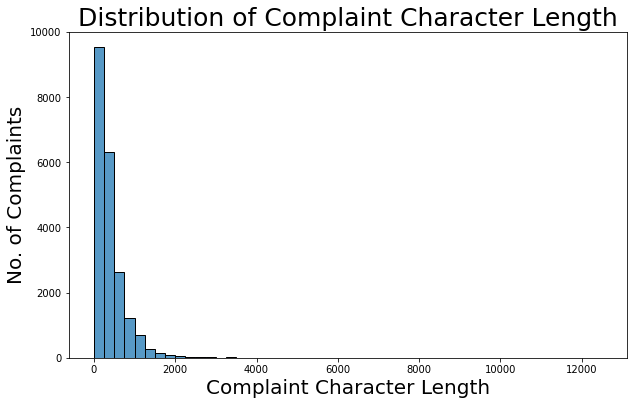

In [245]:

# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[10,6])
sns.histplot(data = char_len,bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

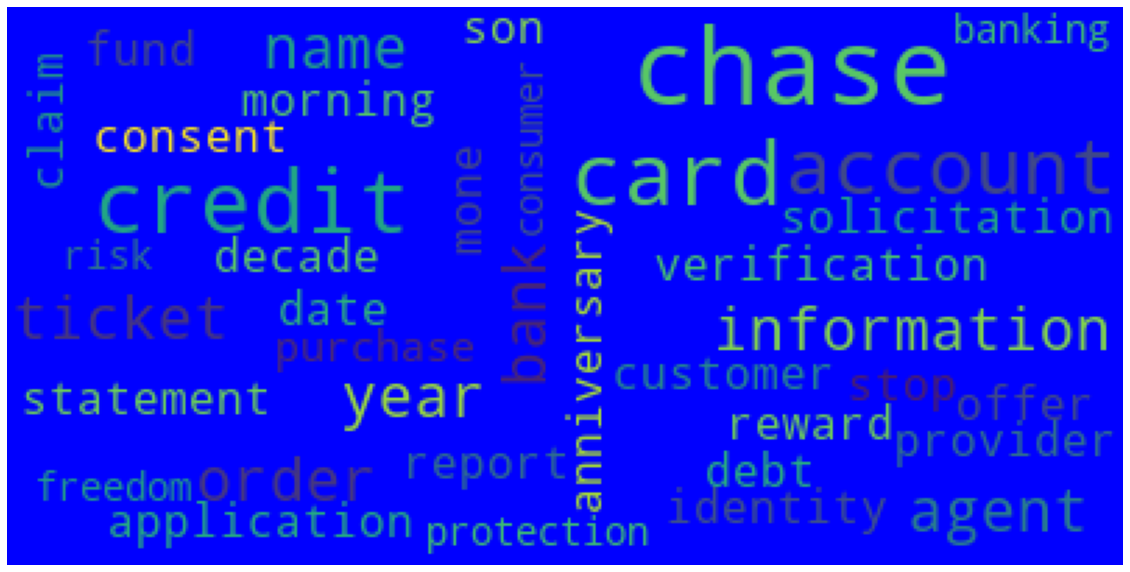

In [246]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
#nltk.download('all')
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='blue',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38, 
                          random_state=42
                         ).generate(str(data_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,16))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [247]:
#Removing -PRON- from the text corpus
data_clean['Complaint_clean'] = data_clean['complaint_POS_removed'].str.replace('-PRON-', '')

/tmp/ipykernel_455/2343780591.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [ ]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(data_clean['complaint_POS_removed'].values.astype('U'))
data_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
data_unigram.head(10)

,unigram,count
0,chase,62400
1,account,46954
2,credit,33319
3,card,30085
4,payment,21298
5,bank,17594
6,time,16267
7,charge,14490
8,day,13118
9,money,11994


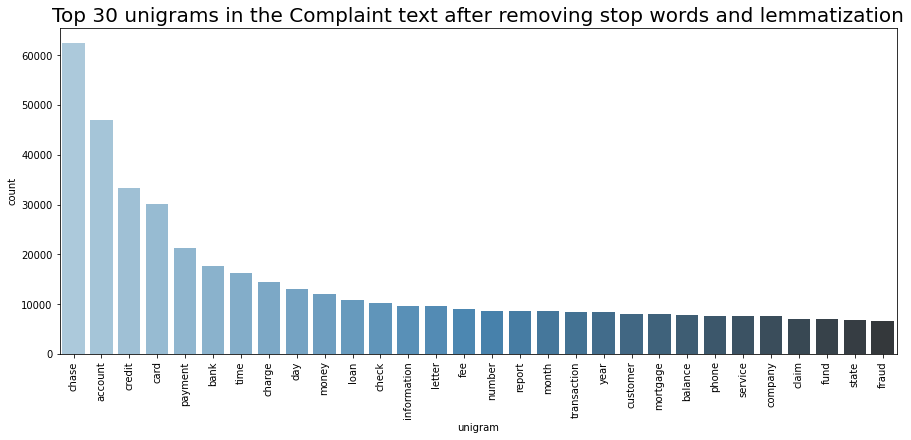

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=data_unigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]
top_common_words = get_top_bigram(data_clean['complaint_POS_removed'].values.astype('U'))
data_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
data_bigram.head(10)

,bigram,count
0,credit card,12691
1,credit report,3938
2,chase credit,3601
3,account chase,3567
4,checking account,3466
5,customer service,2947
6,chase account,2917
7,account account,2558
8,chase bank,2450
9,bank account,2249


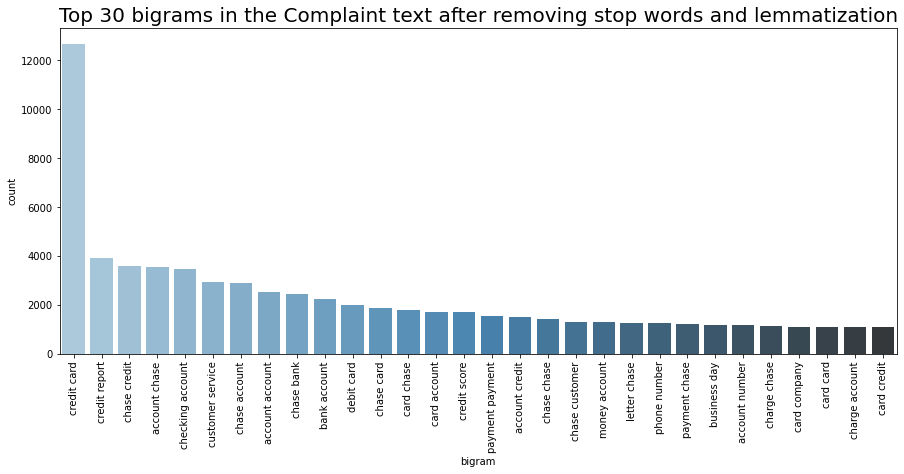

In [ ]:
# Plot the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=data_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [ ]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(data_clean['complaint_POS_removed'].values.astype('U'))
data_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
data_trigram.head(10)

,trigram,count
0,chase credit card,2483
1,credit card account,1084
2,credit card company,992
3,credit card chase,818
4,chase customer service,588
5,credit card credit,537
6,chase checking account,518
7,inquiry credit report,515
8,account credit card,436
9,checking account chase,407


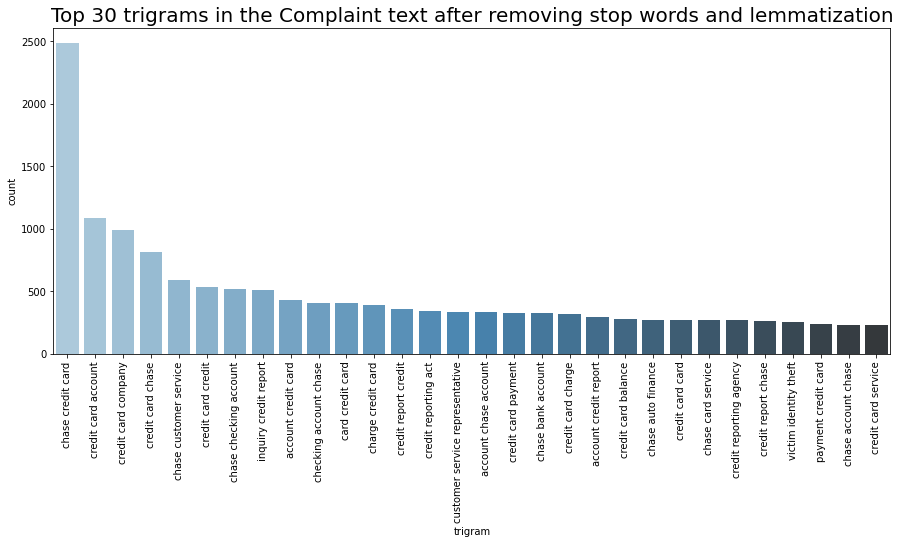

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=data_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
data_clean['Complaint_clean'] = data_clean['Complaint_clean'].str.replace('xxxx','')

/tmp/ipykernel_455/653596589.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#All masked texts has been removed
data_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,agent anniversary date agent information order...,agent anniversary date agent information order...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...,chase card report application identity consent...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm=tfidf.fit_transform(data_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics) #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



6287

In [ ]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,checking,branch,day,transaction,number,business,claim,transfer
Topic 2,card,charge,chase,credit,dispute,fee,transaction,purchase,fraud,service,merchant,time,balance,claim,company
Topic 3,loan,mortgage,chase,home,modification,property,year,letter,document,time,rate,foreclosure,house,sale,request
Topic 4,credit,report,inquiry,card,account,score,company,debt,information,reporting,chase,application,identity,limit,bureaus
Topic 5,payment,balance,month,fee,statement,auto,day,time,chase,pay,credit,date,account,year,mortgage


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)


array([0, 0, 3, ..., 1, 4, 4])

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

data_clean['Topic'] =topic_results.argmax(axis=1) #write your code to assign topics to each rows.

/tmp/ipykernel_455/3324268224.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...,chase card report application identity consent...,3
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
data_clean=data_clean.groupby('Topic').head(5)
data_clean.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandle account chase auto,mishandle account chase auto,0
45,i made a purchase with xxxx xxxx xxxx on xx/xx...,I make a purchase with xxxx xxxx xxxx on xx / ...,purchase amount transaction dispute case charg...,purchase amount transaction dispute case charg...,1
40,"xxxx xxxx a sofa, love seat, table and chairs ...","xxxx xxxx a sofa , love seat , table and chair...",sofa love seat table chair debit card charge v...,sofa love seat table chair debit card charge v...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase amazon card decline catering order place...,chase amazon card decline catering order place...,1
30,"to whom it may concern, chase bank charged wro...","to whom it may concern , chase bank charge wro...",concern charge overdraft fee alert balance fee...,concern charge overdraft fee alert balance fee...,1
21,"on xxxx xx/xx/, i made a {$.} payment to an on...","on xxxx xx / xx/ , I make a { $ . } payment to...",payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
data_clean['Topic'] = data_clean['Topic'].map(Topic_names)

/tmp/ipykernel_455/3392377637.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Account Services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,agent anniversary date agent information order...,agent anniversary date agent information order...,Account Services
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...,chase card report application identity consent...,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Account Services
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,Credit card or prepaid card
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,account debit card branch customer service rep...,account debit card branch customer service rep...,Account Services
20,"during the summer months, i experience a decli...","during the summer month , I experience a decli...",summer month decline income employment month p...,summer month decline income employment month p...,Theft/Dispute Reporting
21,"on xxxx xx/xx/, i made a {$.} payment to an on...","on xxxx xx / xx/ , I make a { $ . } payment to...",payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,Others
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics
Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
data_clean['Topic'] = data_clean['Topic'].map(Topic_names)

/tmp/ipykernel_455/3905159401.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
data_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,agent anniversary date agent information order...,agent anniversary date agent information order...,0
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...,chase card report application identity consent...,3
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,3
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,3
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
20,"during the summer months, i experience a decli...","during the summer month , I experience a decli...",summer month decline income employment month p...,summer month decline income employment month p...,4
21,"on xxxx xx/xx/, i made a {$.} payment to an on...","on xxxx xx / xx/ , I make a { $ . } payment to...",payment retailer chase pay chase website scam ...,payment retailer chase pay chase website scam ...,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card credit report company issue,chase credit card credit report company issue,3


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=data_clean.drop(['lemmatized_complaint', 'complaint_POS_removed', 'Complaint_clean'], axis=1)

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaint_what_happened)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [ ]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

## LOGISTIC REGRESSION 

In [ ]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

## DECISION TREE

In [ ]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

## RANDOM FOREST CLASSIFIER

In [ ]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

## GAUSSIAN NAIVE BAYES

In [ ]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))